In [17]:
import os
import io
import json
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import numpy as np
from datasets import load_dataset

In [18]:
train_dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
val_dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

# example = train_dataset[0]["ground_truth"]
# example_json = json.loads(example)
# boxes=[]

# for line in example_json.get('valid_line', []):
#     category = line.get('category', '')
                
#     for word in line.get('words', []):
#         if 'quad' not in word:
#             continue
                    
#         x_coords = [float(word['quad'][f'x{i}']) for i in range(1, 5)]
#         y_coords = [float(word['quad'][f'y{i}']) for i in range(1, 5)]
             
#         print ("x_coords", x_coords)
#         print ("y_coords", y_coords)
#         boxes.append([
#             min(x_coords),
#             min(y_coords),
#             max(x_coords),
#             max(y_coords)
#         ])
#         print(boxes)
#         print(len(boxes))

In [19]:
category_map = {
    "menu.nm": 0,
    "menu.cnt": 1,
    "menu.price": 2,
    "background": 3  # Untuk anchor yang tidak match dengan GT
}

In [20]:
#hyper_param
STEPS_PER_EPOCH = 100
EPOCH = 25
INITIAL_LR = 1e-4
MOMENTUM = 0.9
GRADIENT_CLIP_NORM = 1.0
STD_DEV = 0.01

In [21]:
from keras.applications import ResNet50V2
from keras import layers, Model
from keras.layers import Input, Conv2D, Concatenate, UpSampling2D, Dense, Reshape

# Backbone model
pre_trained_model = ResNet50V2(input_shape=(640, 640, 3),
                              include_top=False,
                              weights='imagenet')

# Get feature maps at different scales
c3_output = pre_trained_model.get_layer("conv3_block4_out").output  # 75x75
c4_output = pre_trained_model.get_layer("conv4_block6_out").output  # 38x38
c5_output = pre_trained_model.get_layer("conv5_block3_out").output  # 19x19

# Build FPN (Feature Pyramid Network)
# Top-down pathway
p5 = Conv2D(64, 1, padding='same', activation='relu')(c5_output)  # stride 32
p5_upsampled = UpSampling2D(size=(1, 1), interpolation='bilinear')(p5) 

p4 = Conv2D(64, 1, padding='same', activation='relu')(c4_output)  # stride 16
p4 = Concatenate()([p5_upsampled, p4])
p4 = Conv2D(64, 3, padding='same', activation='relu')(p4)
p4_upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(p4)  # 32x32 → 64x64

p3 = Conv2D(64, 1, padding='same', activation='relu')(c3_output)  # stride 8
p3 = Concatenate()([p4_upsampled, p3])
p3 = Conv2D(64, 3, padding='same', activation='relu')(p3)

# Final feature map for detection
features = p3

70800
# Calculate total anchors based on ACTUAL feature map size
height, width = 40, 40  # From your error message
num_anchors_per_location = 9  # 3 scales × 3 ratios
total_anchors = height * width * num_anchors_per_location  # 40×40×9 = 14400

# Classification Head
cls_head = Conv2D(64, 3, padding='same', activation='relu')(features)
cls_head = Conv2D(num_anchors_per_location * 4, 3, padding='same')(cls_head)  # 4 classes
cls_output = Reshape((total_anchors, 4))(cls_head)  # (None, 14400, 4)
cls_output = layers.Activation('softmax', dtype='float32', name='class_output')(cls_output)

# Regression Head
reg_head = Conv2D(64, 3, padding='same', activation='relu')(features)
reg_head = Conv2D(num_anchors_per_location * 4, 3, padding='same')(reg_head)
bbox_output = Reshape((total_anchors, 4))(reg_head)  # (None, 14400, 4)
bbox_output = layers.Activation('sigmoid', dtype='float32', name='bbox_output')(bbox_output)

model = Model(inputs=pre_trained_model.input, outputs=[cls_output, bbox_output])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 640, 640, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 646, 646, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 320, 320, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 322, 322, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 160, 160, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 160, 160, 64)   │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 160, 160, 64)   │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 160, 160, 64)   │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 160, 160, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 160, 160, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 162, 162, 64)   │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 160, 160, 64)   │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 160, 160, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 160, 160, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 24,049,160 (91.74 MB)

 Trainable params: 24,007,816 (91.58 MB)

 Non-trainable params: 41,344 (161.50 KB)

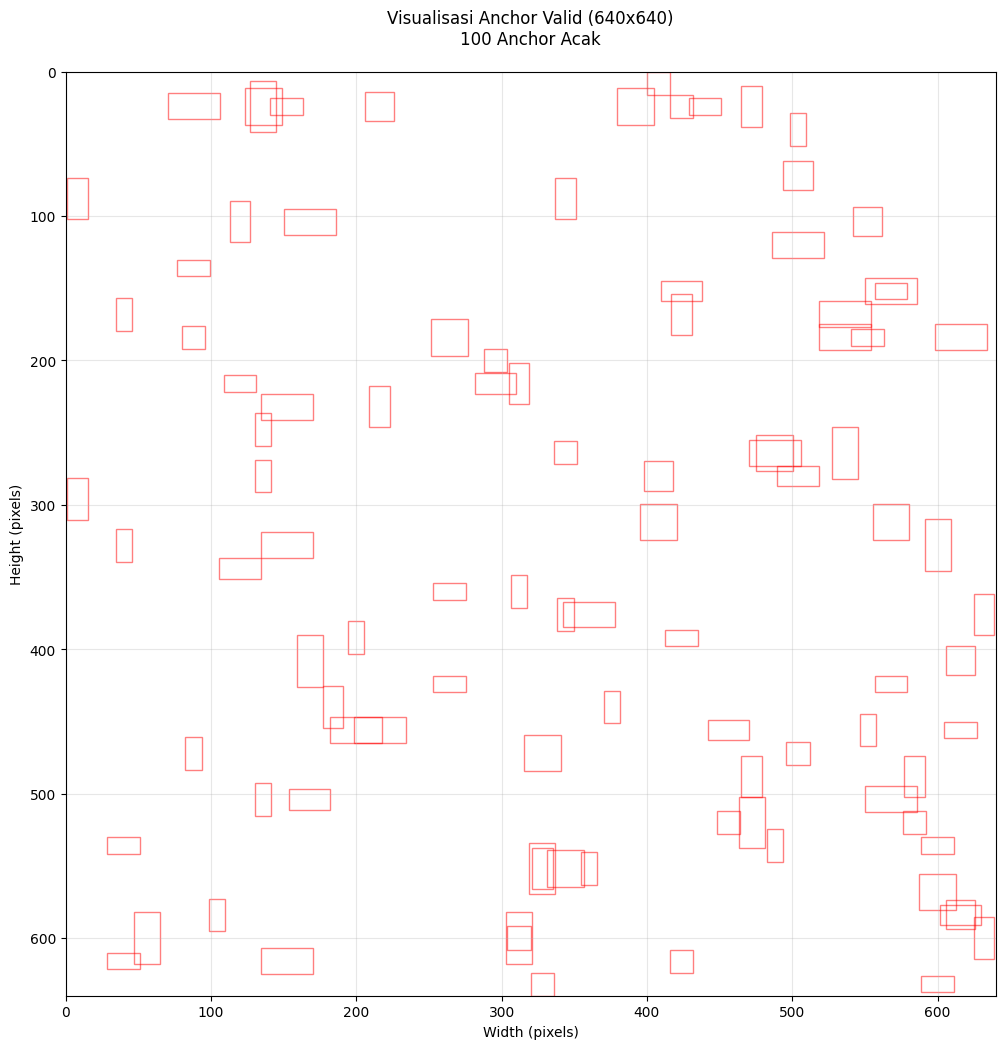

Total anchors generated: 14400
Valid anchors: 13456
Sample anchor: [ 0.  0. 16. 16.]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def generate_anchors(base_size, ratios, scales):
    """Generate base anchors dengan format [x1, y1, x2, y2]"""
    anchors = []
    for scale in scales:
        for ratio in ratios:
            w = base_size * scale * np.sqrt(ratio)
            h = base_size * scale / np.sqrt(ratio)
            # Format [x1, y1, x2, y2] relatif terhadap center (0,0)
            anchors.append([-w/2, -h/2, w/2, h/2])
    return np.array(anchors)

def generate_all_anchors(image_shape=(640, 640), feature_strides=[16]):
    """Generate semua anchor untuk semua level feature map"""
    all_anchors = []
    base_anchors = generate_anchors(
        base_size=16,
        ratios=[0.5, 1.0, 2.0],
        scales=[1, 1.26, 1.58]
    )
    
    for stride in feature_strides:
        # Generate grid
        grid_width = image_shape[1] // stride
        grid_height = image_shape[0] // stride
        shift_x = np.arange(grid_width) * stride + stride//2  # Pusat anchor
        shift_y = np.arange(grid_height) * stride + stride//2
        
        shift_x, shift_y = np.meshgrid(shift_x, shift_y)
        shifts = np.stack([shift_x.ravel(), shift_y.ravel()], axis=1)
        
        # Generate level anchors
        level_anchors = base_anchors.reshape((1, -1, 4)) + np.concatenate(
            [shifts, shifts], axis=1).reshape((-1, 1, 4))
        
        all_anchors.append(level_anchors.reshape((-1, 4)))
    
    return np.concatenate(all_anchors, axis=0)

# Generate anchors
anchors = generate_all_anchors()

# Filter anchors yang valid (berada dalam image boundary)
valid_anchors = anchors[
    (anchors[:, 0] >= 0) & 
    (anchors[:, 1] >= 0) & 
    (anchors[:, 2] <= 640) & 
    (anchors[:, 3] <= 640)
]

# Visualisasi 100 anchor acak yang valid
plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.set_xlim([0, 640])
ax.set_ylim([640, 0])  # Image origin di kiri atas

if len(valid_anchors) > 0:
    sample_indices = np.random.choice(len(valid_anchors), min(100, len(valid_anchors)), replace=False)
    for idx in sample_indices:
        x1, y1, x2, y2 = valid_anchors[idx]
        rect = Rectangle(
            (x1, y1), 
            x2-x1, 
            y2-y1,
            linewidth=1, 
            edgecolor='r', 
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)
else:
    print("Tidak ada anchor yang valid!")

plt.title('Visualisasi Anchor Valid (640x640)\n100 Anchor Acak', pad=20)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, alpha=0.3)
plt.show()

# Print info anchor
print(f"Total anchors generated: {len(anchors)}")
print(f"Valid anchors: {len(valid_anchors)}")
print(f"Sample anchor: {valid_anchors[0] if len(valid_anchors) > 0 else 'N/A'}")

In [23]:
import tensorflow as tf
import numpy as np
from typing import Dict, Tuple, List
from datasets import load_dataset

class RetinaNetDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, category_map, image_size=(640, 640), batch_size=4, shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset  # Keep as HuggingFace Dataset
        self.anchors = anchors
        self.category_map = category_map
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(dataset)).astype(int)  # Ensure integer type
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images = []
        batch_cls = []
        batch_reg = []
        
        for i in batch_indices:
            try:
                example = self.dataset[int(i)]
                
                # Process image
                image = np.array(example['image'])
                image = tf.image.resize(image, self.image_size)
                image = tf.cast(image, tf.float32) / 255.0

                # === AUGMENTASI AMAN ===
                if self.augment:
                    if tf.random.uniform([]) < 0.5:
                        image = tf.image.random_brightness(image, max_delta=0.2)
                    if tf.random.uniform([]) < 0.5:
                        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
                    if tf.random.uniform([]) < 0.5:
                        image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
                    if tf.random.uniform([]) < 0.2:
                        image = tf.image.adjust_hue(image, delta=tf.random.uniform([], -0.05, 0.05))
                
                # Get ground truth
                boxes, labels = self._get_gt_boxes_and_labels(json.loads(example["ground_truth"]))
                
                # Match anchors
                cls_target, reg_target = self._match_anchors_to_gt(boxes, labels)
                
                batch_images.append(image)
                batch_cls.append(cls_target)
                batch_reg.append(reg_target)
                
            except Exception as e:
                print(f"Error processing example {i}: {str(e)}")
                # Return empty arrays if error occurs
                empty_cls = np.zeros(len(self.anchors), dtype=np.int32)
                empty_reg = np.zeros((len(self.anchors), 4), dtype=np.float32)
                batch_images.append(np.zeros(self.image_size + (3,), dtype=np.float32))
                batch_cls.append(empty_cls)
                batch_reg.append(empty_reg)
        
        # Convert to numpy arrays with proper error handling
        if not batch_cls:  # If completely empty
            batch_cls = [np.zeros(len(self.anchors), dtype=np.int32) for _ in batch_indices]
            batch_reg = [np.zeros((len(self.anchors), 4), dtype=np.float32) for _ in batch_indices]
        
        # Stack arrays
        batch_images = tf.stack(batch_images)
        batch_cls = np.stack(batch_cls)
        batch_reg = np.stack(batch_reg)
        
        # Convert to one-hot
        num_classes = len(self.category_map)
        batch_cls_onehot = tf.one_hot(
            tf.maximum(batch_cls, 0),  # Convert -1 to 0
            depth=num_classes
        )
        
        return (
            batch_images,
            {
                'class_output': batch_cls_onehot,
                'bbox_output': tf.cast(batch_reg, tf.float32)
            }
        )

    def _get_gt_boxes_and_labels(self, example):
        """Extract boxes with proper type handling"""
        boxes = []
        labels = []
        
        for line in example.get('valid_line', []):
            category = line.get('category', '')
            if category not in self.category_map:
                continue
                
            for word in line.get('words', []):
                if 'quad' not in word:
                    continue
                    
                # Convert coordinates to float32
                x_coords = [float(word['quad'][f'x{i}']) for i in range(1, 5)]
                y_coords = [float(word['quad'][f'y{i}']) for i in range(1, 5)]
                
                boxes.append([
                    min(x_coords),
                    min(y_coords),
                    max(x_coords),
                    max(y_coords)
                ])
                labels.append(int(self.category_map[category]))
        
        if not boxes:
            return np.zeros((0, 4), dtype=np.float32), np.zeros((0,), dtype=np.int32)
            
        # Normalize to [0,1]
        boxes = np.array(boxes, dtype=np.float32)
        boxes[:, [0, 2]] /= self.image_size[1]  # width
        boxes[:, [1, 3]] /= self.image_size[0]  # height
        
        return boxes, np.array(labels, dtype=np.int32)

    def _match_anchors_to_gt(self, gt_boxes, gt_labels):
        """Match anchors to ground truth boxes"""
        num_anchors = len(self.anchors)
        cls_target = np.zeros(num_anchors, dtype=np.int32) - 1  # -1 means ignore
        reg_target = np.zeros((num_anchors, 4), dtype=np.float32)
        
        if len(gt_boxes) == 0:
            return cls_target, reg_target
            
        # Calculate IoU between anchors and GT boxes
        iou_matrix = self._calculate_iou(gt_boxes)
        
        # Assign best match per GT
        best_match = np.argmax(iou_matrix, axis=0)
        best_iou = np.max(iou_matrix, axis=0)
        
        for gt_idx in np.where(best_iou > 0.5)[0]:
            anchor_idx = best_match[gt_idx]
            cls_target[anchor_idx] = gt_labels[gt_idx]
            
            # Calculate regression targets
            gt_box = gt_boxes[gt_idx]
            anchor = self.anchors[anchor_idx]
            
            reg_target[anchor_idx, 0] = (gt_box[0] - anchor[0]) / (anchor[2] - anchor[0])  # tx
            reg_target[anchor_idx, 1] = (gt_box[1] - anchor[1]) / (anchor[3] - anchor[1])  # ty
            reg_target[anchor_idx, 2] = np.log((gt_box[2] - gt_box[0]) / (anchor[2] - anchor[0]))  # tw
            reg_target[anchor_idx, 3] = np.log((gt_box[3] - gt_box[1]) / (anchor[3] - anchor[1]))  # th
        
        return cls_target, reg_target

    def _calculate_iou(self, gt_boxes):
        """Calculate IoU between anchors and GT boxes"""
        # Convert to [x1,y1,x2,y2] format
        anchors = self.anchors
        gt_boxes = gt_boxes
        
        # Calculate intersection areas
        inter_x1 = np.maximum(anchors[:, 0][:, None], gt_boxes[:, 0])
        inter_y1 = np.maximum(anchors[:, 1][:, None], gt_boxes[:, 1])
        inter_x2 = np.minimum(anchors[:, 2][:, None], gt_boxes[:, 2])
        inter_y2 = np.minimum(anchors[:, 3][:, None], gt_boxes[:, 3])
        
        inter_area = np.maximum(inter_x2 - inter_x1, 0) * np.maximum(inter_y2 - inter_y1, 0)
        
        # Calculate union areas
        anchor_area = (anchors[:, 2] - anchors[:, 0]) * (anchors[:, 3] - anchors[:, 1])
        gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
        
        union_area = anchor_area[:, None] + gt_area - inter_area
        
        return inter_area / (union_area + 1e-8)  # shape: (num_anchors, num_gt)

    def on_epoch_end(self):
        """Shuffle indices at epoch end"""
        if self.shuffle:
            np.random.shuffle(self.indices),

In [24]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_retinanet.keras",
    monitor="val_loss",             # ganti ke 'val_loss' kalau pakai validation
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir="./logs",
    update_freq="epoch"
)


In [25]:
from tensorflow.keras.optimizers import Adam

anchors = generate_all_anchors()

optimizer = Adam(
    learning_rate=INITIAL_LR,
    beta_1=MOMENTUM,
    clipnorm=GRADIENT_CLIP_NORM
)

model.compile(
    optimizer=optimizer,
    loss={
        "class_output": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        "bbox_output": "mse",
    },
    metrics = {
        "class_output": "accuracy",
        "bbox_output":  "mae"
    }
)

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 640, 640, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 646, 646, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 320, 320, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 322, 322, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 160, 160, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 160, 160, 64)   │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 160, 160, 64)   │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 160, 160, 64)   │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 160, 160, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 160, 160, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 162, 162, 64)   │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 160, 160, 64)   │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 160, 160, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 160, 160, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 24,049,160 (91.74 MB)

 Trainable params: 24,007,816 (91.58 MB)

 Non-trainable params: 41,344 (161.50 KB)

In [27]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('/kaggle/working/training_log.csv', separator=',', append=True)

In [28]:
train_gen = RetinaNetDataGenerator(
        dataset=train_dataset,
        batch_size=8,
        image_size=(640, 640),
        category_map=category_map
    )
    
val_gen = RetinaNetDataGenerator(
        dataset=val_dataset,
        batch_size=8,
        image_size=(640, 640),
        category_map=category_map,
        shuffle=False
    )


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    validation_steps=500,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCH,
    callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb]
)

Epoch 1/25


I0000 00:00:1745556216.518567     118 service.cc:148] XLA service 0x3c000700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745556216.520216     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745556216.520239     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745556223.202094     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745556277.307601     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/250 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - bbox_output_loss: 0.7714 - bbox_output_mae: 0.5003 - class_output_accuracy: 0.3314 - class_output_loss: 0.0886 - loss: 0.8600

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_data = pd.read_csv('/kaggle/working/training_log.csv')

plt.figure(figsize=(16, 12))

# Plot untuk accuracy class_output
plt.subplot(2, 2, 1)
plt.title('Class Output Accuracy')
plt.plot(log_data['epoch'], log_data['class_output_accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_class_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot untuk loss class_output
plt.subplot(2, 2, 2)
plt.title('Class Output Loss (Categorical Crossentropy)')
plt.plot(log_data['epoch'], log_data['class_output_loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_class_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot untuk MAE bbox_output
plt.subplot(2, 2, 3)
plt.title('BBox Output MAE')
plt.plot(log_data['epoch'], log_data['bbox_output_mae'], label='Training MAE')
plt.plot(log_data['epoch'], log_data['val_bbox_output_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot untuk MSE loss bbox_output
plt.subplot(2, 2, 4)
plt.title('BBox Output Loss (MSE)')
plt.plot(log_data['epoch'], log_data['bbox_output_loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_bbox_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("obj_resnet50v2_v2.h5")
model.save("obj_resnet50v2_v2.keras")
print("Model saved successfully!")

In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import os

In [ ]:
drive_service = build('drive', 'v3')

folder_id = "1a0i_DpxSo1RnkT7ZjUr_AdawVvW2vBSX"  # Dapatkan dari URL Google Drive folder kamu

# # # Zip folder SavedModel
# # shutil.make_archive("final_faster_rcnn_resnet50v2", 'zip', "final_faster_rcnn_resnet50v2")

# # file_metadata = {
# #     "name": "final_faster_rcnn_resnet50v2",
# #     "parents": [folder_id]
# # }
# # media_savedmodel = MediaFileUpload("final_faster_rcnn_resnet50v2", mimetype="application/octet-stream")
# # file_savedmodel = drive_service.files().create(body=file_metadata_savedmodel, media_body=media_savedmodel, fields="id").execute()
# # print(f"File uploaded with ID: {file_savedmodel.get('id')}")

file_metadata = {
    "name": "obj_resnet50v2_v2.keras",
    "parents": [folder_id]
}
media = MediaFileUpload("obj_resnet50v2_v2.keras", mimetype="application/octet-stream")

file = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
print(f"File uploaded with ID: {file.get('id')}")

file_metadata_h5 = {
    "name": "obj_resnet50v2_v2.h5",
    "parents": [folder_id]
}
media_h5 = MediaFileUpload("obj_resnet50v2_v2.h5", mimetype="application/octet-stream")

file_h5 = drive_service.files().create(body=file_metadata_h5, media_body=media_h5, fields="id").execute()
print(f"File uploaded with ID: {file_h5.get('id')}")